In [1]:
import pandas as pd
import numpy as np

from keras.layers import Dense,LSTM,Dropout
from keras.models import Sequential

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [2]:
#Reading the CSV file
df = pd.read_csv("C:\\Users\\kanan\\Desktop\\Study Material\\In-house CP\\Untitled Folder\\cleaned_weatherAUS.csv")

In [3]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,2009-09-02,Albury,1.0,16.8,0.0,ESE,24.0,ESE,E,9.0,9.0,82.0,45.0,1024.9,1020.2,7.0,16.0,No,No,9
1,2009-09-03,Albury,6.1,20.7,0.0,NE,43.0,SE,NE,4.0,24.0,80.0,54.0,1016.6,1010.8,10.2,20.3,No,Yes,9
2,2009-09-04,Albury,6.3,16.9,1.4,NW,35.0,ESE,WNW,6.0,13.0,85.0,58.0,1014.4,1012.3,12.5,15.5,Yes,No,9
3,2009-09-05,Albury,2.1,15.0,0.0,WNW,30.0,ESE,NW,4.0,11.0,81.0,54.0,1019.5,1017.9,8.6,14.9,No,No,9
4,2009-09-06,Albury,1.6,16.6,0.0,NE,37.0,SE,NE,9.0,20.0,79.0,47.0,1018.4,1011.4,8.3,15.4,No,No,9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109523 entries, 0 to 109522
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           109523 non-null  object 
 1   Location       109523 non-null  object 
 2   MinTemp        109523 non-null  float64
 3   MaxTemp        109523 non-null  float64
 4   Rainfall       109523 non-null  float64
 5   WindGustDir    109523 non-null  object 
 6   WindGustSpeed  109523 non-null  float64
 7   WindDir9am     109523 non-null  object 
 8   WindDir3pm     109523 non-null  object 
 9   WindSpeed9am   109523 non-null  float64
 10  WindSpeed3pm   109523 non-null  float64
 11  Humidity9am    109523 non-null  float64
 12  Humidity3pm    109523 non-null  float64
 13  Pressure9am    109523 non-null  float64
 14  Pressure3pm    109523 non-null  float64
 15  Temp9am        109523 non-null  float64
 16  Temp3pm        109523 non-null  float64
 17  RainToday      109523 non-nul

In [5]:
df.isna().mean().round(4) * 100

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
Month            0.0
dtype: float64

In [6]:
Direction = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
Degree = []

x = 0
for i in range(0,337,22):
    Degree.append(i+x)
    x = x + 0.5
    
Direction_Degree = dict(zip(Direction,Degree))
print(Direction_Degree)

#Converting WindGustDir, WindDir9am, WindDir3pm to degree format

df = df.replace({"WindGustDir": Direction_Degree})
df = df.replace({"WindDir9am": Direction_Degree})
df = df.replace({"WindDir3pm": Direction_Degree})

{'N': 0, 'NNE': 22.5, 'NE': 45.0, 'ENE': 67.5, 'E': 90.0, 'ESE': 112.5, 'SE': 135.0, 'SSE': 157.5, 'S': 180.0, 'SSW': 202.5, 'SW': 225.0, 'WSW': 247.5, 'W': 270.0, 'WNW': 292.5, 'NW': 315.0, 'NNW': 337.5}


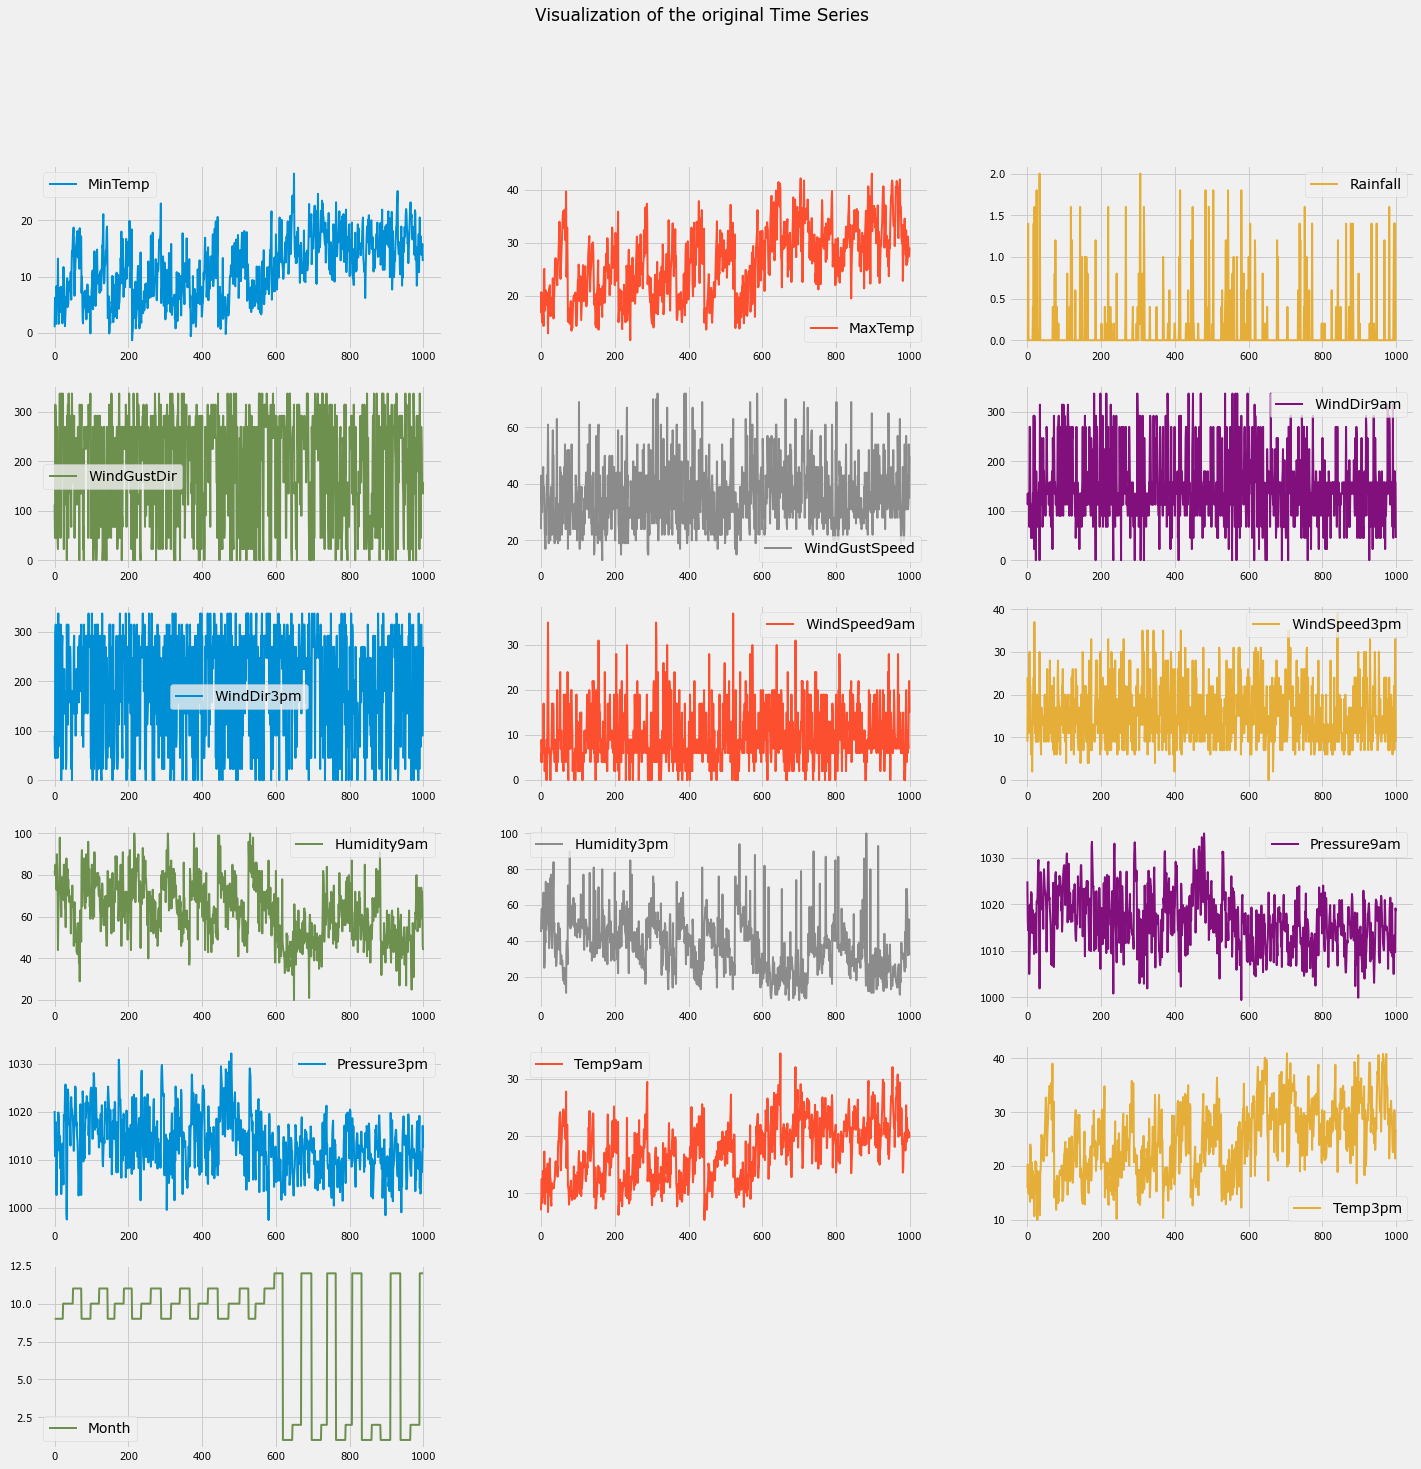

In [7]:
# Plot the time series
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df[:1000].plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

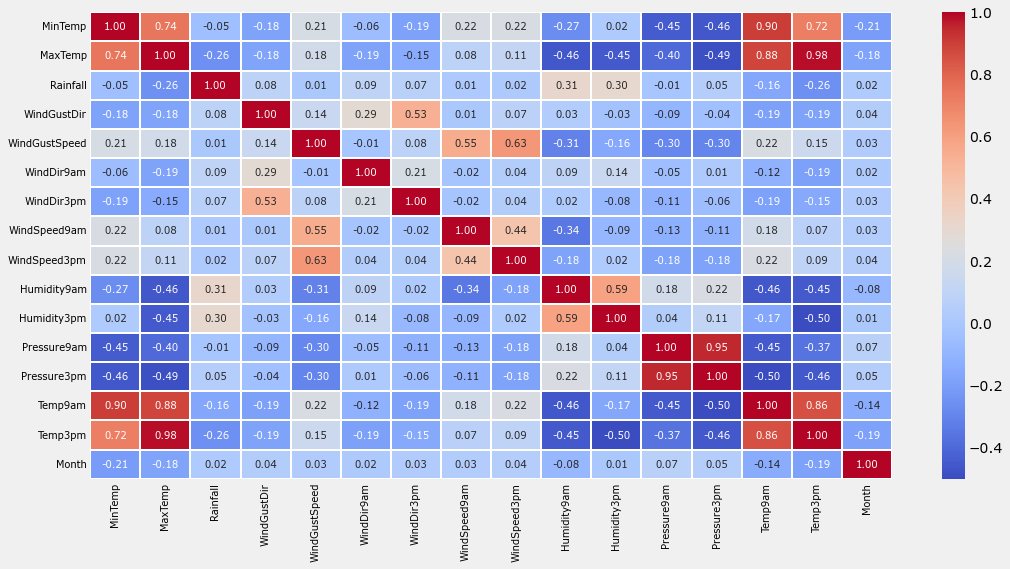

In [8]:
# Let's also draw a heatmap visualization of the correlation matrix

import seaborn as sns
corr_matrix = df.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [9]:
# Converting date to date_time objects for plotting the data
train_dates = pd.to_datetime(df['Date'])
train_dates

0        2009-09-02
1        2009-09-03
2        2009-09-04
3        2009-09-05
4        2009-09-06
            ...    
109518   2017-06-20
109519   2017-06-21
109520   2017-06-22
109521   2017-06-23
109522   2017-06-24
Name: Date, Length: 109523, dtype: datetime64[ns]

In [10]:
df = df.drop(columns = ['Date','Location','Month'],axis=1)

In [11]:
df

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,1.0,16.8,0.0,112.5,24.0,112.5,90.0,9.0,9.0,82.0,45.0,1024.9,1020.2,7.0,16.0,No,No
1,6.1,20.7,0.0,45.0,43.0,135.0,45.0,4.0,24.0,80.0,54.0,1016.6,1010.8,10.2,20.3,No,Yes
2,6.3,16.9,1.4,315.0,35.0,112.5,292.5,6.0,13.0,85.0,58.0,1014.4,1012.3,12.5,15.5,Yes,No
3,2.1,15.0,0.0,292.5,30.0,112.5,315.0,4.0,11.0,81.0,54.0,1019.5,1017.9,8.6,14.9,No,No
4,1.6,16.6,0.0,45.0,37.0,135.0,45.0,9.0,20.0,79.0,47.0,1018.4,1011.4,8.3,15.4,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109518,3.5,21.8,0.0,90.0,31.0,112.5,90.0,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No,No
109519,2.8,23.4,0.0,90.0,31.0,135.0,67.5,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No
109520,3.6,25.3,0.0,337.5,22.0,135.0,0.0,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No
109521,5.4,26.9,0.0,0.0,37.0,135.0,292.5,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No


In [12]:
from sklearn.preprocessing import LabelEncoder

cat_f = [x for x in df.columns if df[x].dtype == 'object']
print(cat_f)

# traversing all columns for converting into continuous valriables
for name in cat_f:
    enc = LabelEncoder()
    enc.fit(list(df[name].values.astype('str')) + list(df[name].values.astype('str')))
    df[name] = enc.transform(df[name].values.astype('str'))

['RainToday', 'RainTomorrow']


In [ ]:
# Converting all objects to float type
df_for_training = df.astype(float)
df_for_training.shape

In [18]:
# Split train and test data
train_features = df.loc[0:87623]
train_labels = df.loc[0:87623, 'RainTomorrow']

test_features = df.loc[87623:109522]
test_labels = df.loc[87623:109522, 'RainTomorrow']
# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window
T = 15  # my choice of the timesteps window

prepend_features = train_features.iloc[-(T-1):]
#print(prepend_features)
test_features = pd.concat([prepend_features, test_features], axis=0)

train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((87624, 17), (87624,), (21914, 17), (21900,))

In [19]:
# Rescale the features
from sklearn.preprocessing import StandardScaler  # MinMaxScaler

scaler = StandardScaler()  # MinMaxScaler(feature_range=(-1,1))
scaled_train_features = pd.DataFrame(scaler.fit_transform(train_features.values),
                                     index=train_features.index,
                                     columns=train_features.columns)
# The Scaler is fit on the training set and then applied to the test set
scaled_test_features = pd.DataFrame(scaler.transform(test_features.values),
                                    index=test_features.index,
                                    columns=test_features.columns)

scaled_train_features.shape, scaled_test_features.shape

((87624, 17), (21914, 17))

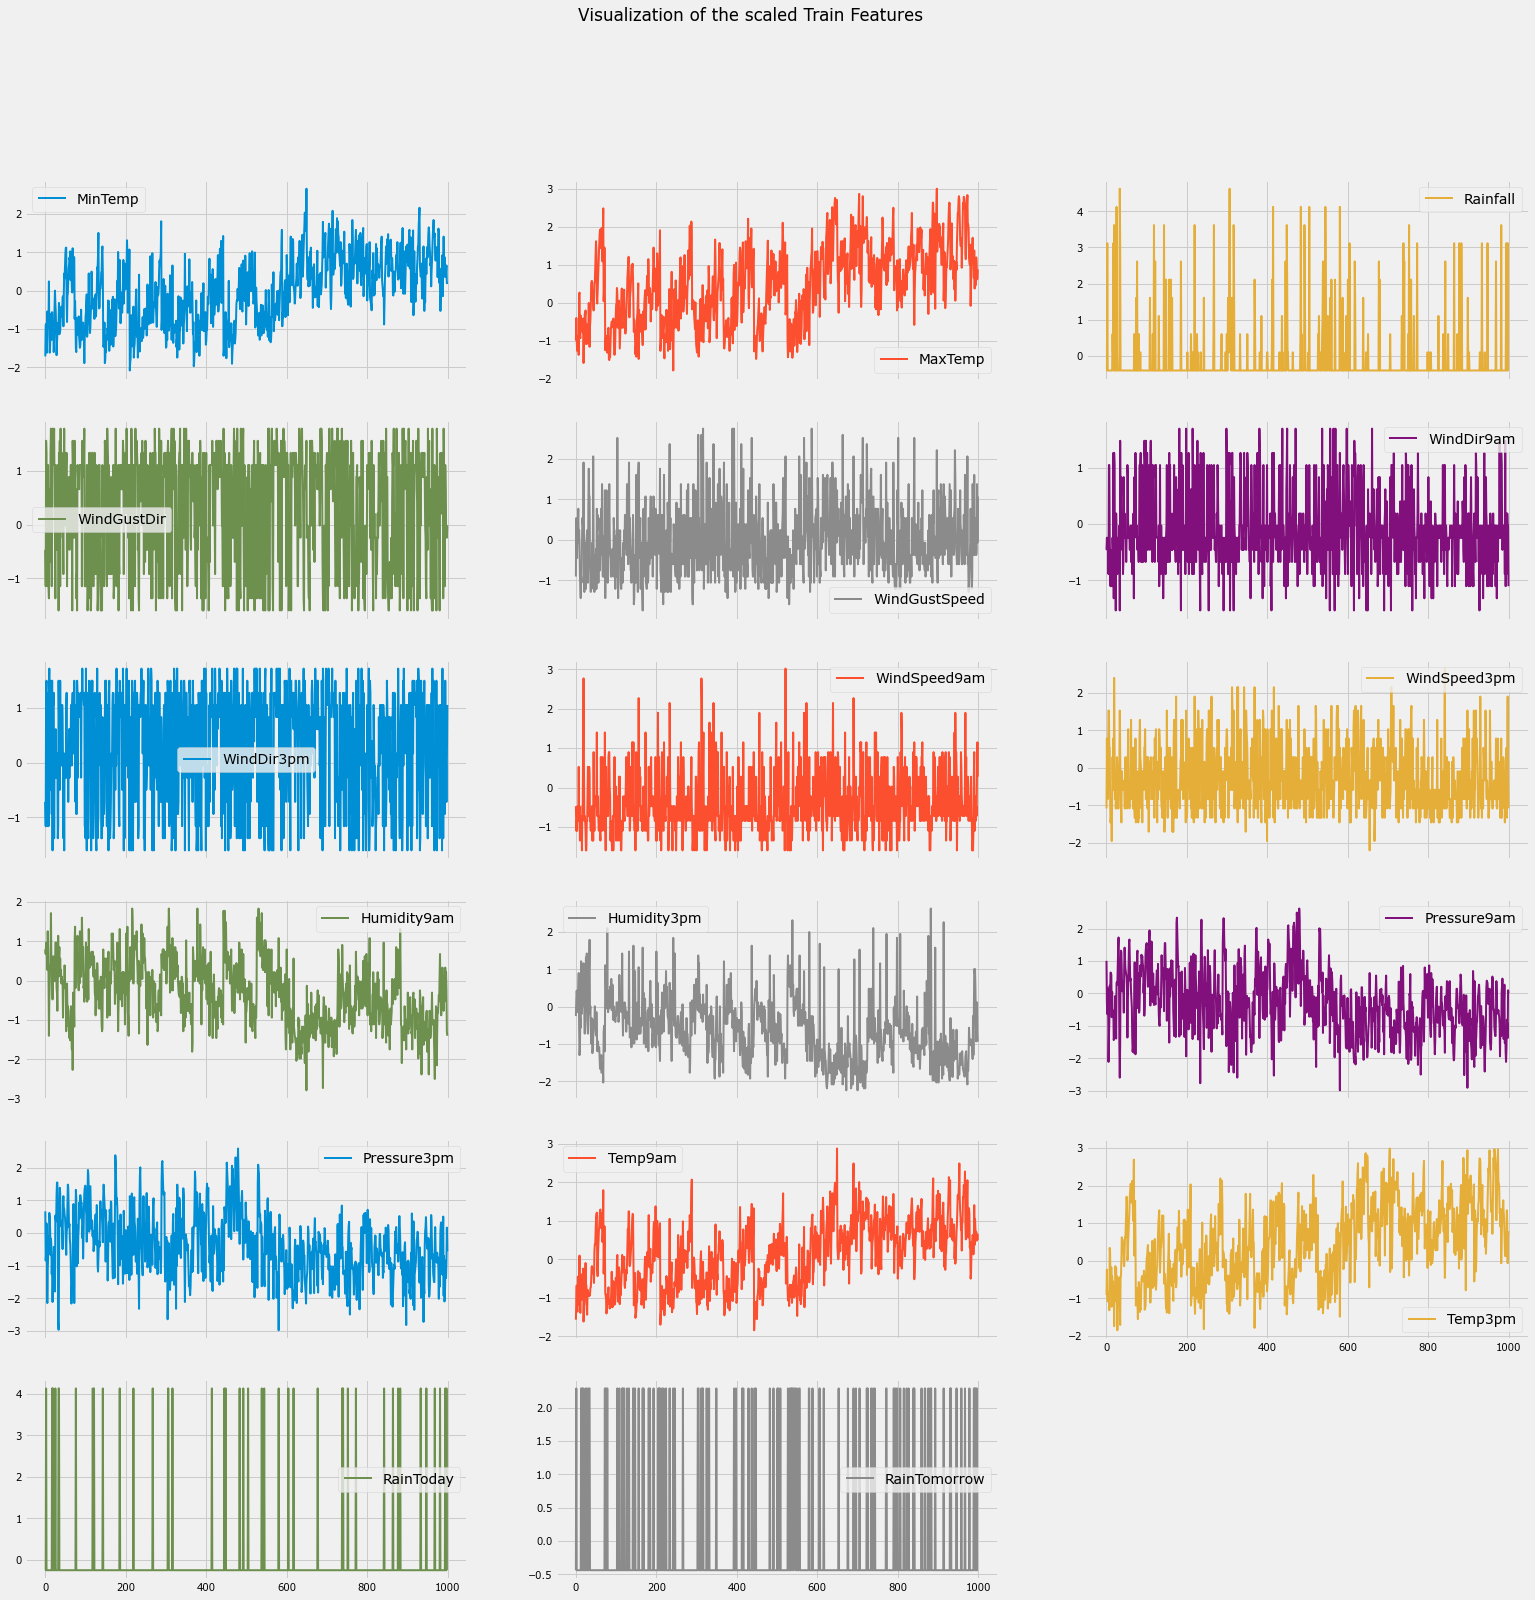

In [20]:
# Plot the rescaled_train_features
plt.style.use('fivethirtyeight')
scaled_train_features[:1000].plot(subplots=True,
                           layout=(6, 3),
                           figsize=(24,24),
                           fontsize=10, 
                           linewidth=2, 
                           title='Visualization of the scaled Train Features')
plt.show()

In [22]:
# Create sequences of T timesteps
X_train, y_train = [], []
for i in range(train_labels.shape[0] - (T-1)):
    X_train.append(scaled_train_features.iloc[i:i+T].values)
    y_train.append(train_labels.iloc[i + (T-1)])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
#print(test_labels.shape)
for i in range(test_labels.shape[0]):
    X_test.append(scaled_test_features.iloc[i:i+T].values)
    y_test.append(test_labels.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)  

print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (87610, 15, 17), (87610, 1)
Test data dimensions: (21900, 15, 17), (21900, 1)


In [25]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

In [53]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [64, 32, 16, 1]                # number of units in hidden and output layers

M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]

N = X_train.shape[2]                 # number of features

BATCH = 64                      # batch size
EPOCH = 25                           # number of epochs

LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion

DP = 0.2                             # dropout rate
RDP = 0.1                            # recurrent dropout rate

print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')


# Build the Model
model = Sequential()

model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())

model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())

model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())

model.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.2,
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)

print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


layers=[64, 32, 16, 1], train_examples=87610, test_examples=21900
batch = 64, timesteps = 15, features = 17, epochs = 25
lr = 0.05, lambda = 0.03, dropout = 0.2, recurr_dropout = 0.1
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 15, 64)            20992     
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 64)            256       
_________________________________________________________________
lstm_10 (LSTM)               (None, 15, 32)            12416     
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 32)            128       
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                3136      
_________________________________________________________________
bat

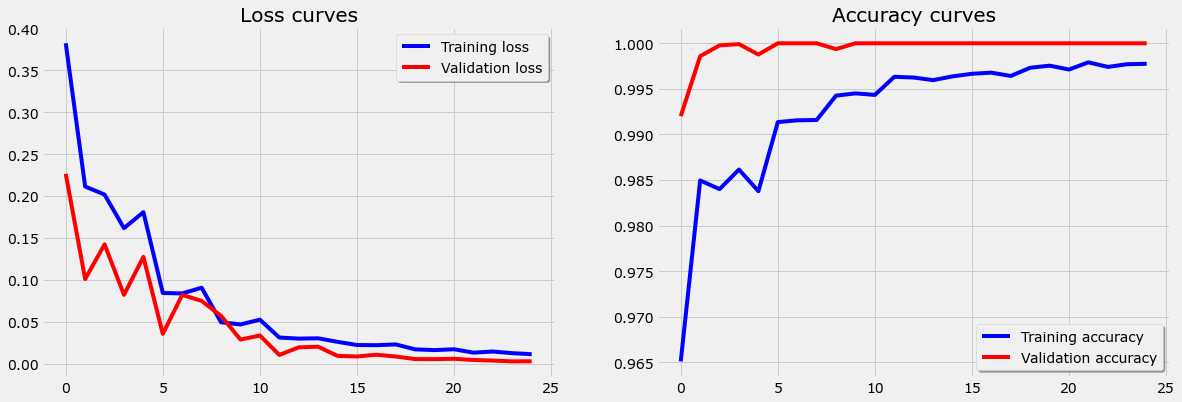

In [54]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)

axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [55]:
model.save('Models/LSTM_Classifier_1')

INFO:tensorflow:Assets written to: Models/LSTM_Classifier_1\assets


In [56]:
y_hat = model.predict_classes(X_test, batch_size=M_TEST, verbose=1)

1/1 [==============================] - 0s 2ms/step


In [57]:
y_hat.shape

(21900, 1)

In [58]:
y_test.shape

(21900, 1)

In [59]:
y_test[:150]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
    

In [60]:
y_hat[:150]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
    

In [61]:
data = {'y_Actual':  y_test.ravel(),
        'y_Predicted': y_hat.ravel()
        }
#print(data)

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted      0     1
Actual                
0          18785     0
1              0  3115


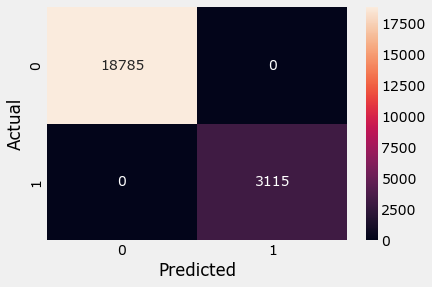

In [62]:
import seaborn as sn

sn.heatmap(confusion_matrix, annot=True,fmt='d')
plt.show()

In [63]:
from sklearn.metrics import precision_score,accuracy_score

print("Precision is : ",precision_score(y_test,y_hat))
print("Accuracy is : ",accuracy_score(y_test,y_hat))

Precision is :  1.0
Accuracy is :  1.0


In [49]:
import tensorflow as tf
classifier = tf.keras.models.load_model('Models/LSTM_Classifier')

In [52]:
y_hat = classifier.predict_classes(X_test, batch_size=M_TEST, verbose=1)

data = {'y_Actual':  y_test.ravel(),
        'y_Predicted': y_hat.ravel()
        }
#print(data)

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

from sklearn.metrics import precision_score,accuracy_score

print("Precision is : ",precision_score(y_test,y_hat))
print("Accuracy is : ",accuracy_score(y_test,y_hat))

1/1 [==============================] - 0s 0s/step
Predicted      0     1
Actual                
0          18785     0
1              0  3115
Precision is :  1.0
Accuracy is :  1.0


In [ ]:
# Converting the dataset into training dataset using timesteps and number of future values to be predicted
trainX = []
trainY = []

n_future = 1 # this much future values will be predicted given single value of input
n_past = 10

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future-1:i+n_future,16])
    
# Converting it to numpy array
trainX, trainY = np.array(trainX),np.array(trainY)

In [ ]:
print(trainX.shape)
print(trainY.shape)

In [ ]:
# Scaling the value between -1 to 1
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
# Creating Sequential model for training using LSTM, Dropout and Dense layers
regressor = Sequential()

regressor.add(LSTM(64,activation='relu',return_sequences=True,input_shape=(trainX.shape[1],trainX.shape[2])))
regressor.add(LSTM(32))
regressor.add(Dropout(0.2))
regressor.add(Dense(1))

regressor.compile(optimizer='adam',loss='cate',metrics=['accuracy'])

regressor.summary()

In [ ]:
history = regressor.fit(trainX,trainY,
                        shuffle = True, 
                        epochs=25,
                        batch_size=64,
                        validation_split=0.1,
                        verbose=1)

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
regressor.save('Models/Session_3_Rain_Today_Simple_epoch=25')

In [ ]:
# n_future = 2  # This value must be same as the value used while creating training dataset

forecast_period_dates = pd.date_range(list(train_dates)[-1],periods=n_future,freq='1d').tolist()
print(forecast_period_dates)

# Predicting 
forecast = regressor.predict(trainX[-10000:])

print(trainX[-10000:].shape)
print(forecast)

In [ ]:
# for descaling the values we need (x,20) type shape, So we are using np.repeat to copy same values accross df_for_training.shape[1]
forecast_copies = np.repeat(forecast,df_for_training.shape[1],axis=-1)
#print(forecast_copies)

y_pred_future = scaler.inverse_transform(forecast_copies)[:,16]
print(y_pred_future[:100])

In [ ]:
output = list(map(lambda x :1 if x>0.5 else 0,y_pred_future))
print(len(list(output)))
print(output)

In [ ]:
actual_values = df_for_training[-10000:]['RainToday']
#print(len(actual_values.to_numpy()))
#print(actual_values.to_numpy())

In [ ]:
data = {'y_Actual':   list(actual_values.to_numpy()),
        'y_Predicted': output
        }
#print(data)

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

In [ ]:
import seaborn as sn

sn.heatmap(confusion_matrix, annot=True,fmt='d')
plt.show()

In [ ]:
from sklearn.metrics import precision_score,accuracy_score

print("Precision is : ",precision_score(actual_values,output))
print("Accuracy is : ",accuracy_score(actual_values,output))